In [1]:
!nvidia-smi

Sat Dec 28 09:05:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   50C    P8             16W /  170W |    1251MiB /  12288MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import required packages

In [2]:
import albumentations as A
import cv2
import os
import glob
import matplotlib.pyplot as plt
from pathlib import Path
from IPython import display
import ultralytics

/home/rowan/safety-construction/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rowan/safety-construction/venv/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# YOLOv9 Ultralytics

In [3]:
display.clear_output()
ultralytics.checks()

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Setup complete ✅ (20 CPUs, 15.5 GB RAM, 86.6/1006.9 GB disk)


# Prepare data

## Data augmentation

In [4]:
transform = A.Compose(
    [
        A.Rotate(limit=(90, 90), p=1.0),
        A.HorizontalFlip(p=0.5),
    ],
    bbox_params=A.BboxParams(format="yolo", label_fields=["category_ids"])
)

In [5]:
def augment_images(images_dir, labels_dir, save_dir, aug_count=1):
    images_path = sorted(glob.glob(os.path.join(images_dir, "*.jpg")))
    labels_path = sorted(glob.glob(os.path.join(labels_dir, "*.txt")))

    Path(save_dir / "images").mkdir(parents=True, exist_ok=True)
    Path(save_dir / "labels").mkdir(parents=True, exist_ok=True)

    for img_path, lbl_path in zip(images_path, labels_path):
        image = cv2.imread(img_path)
        height, width, _ = image.shape

        with open(lbl_path, "r") as f:
            boxes = []
            category_ids = []
            for line in f:
                class_id, x, y, w, h = map(float, line.strip().split())
                boxes.append([x, y, w, h])
                category_ids.append(int(class_id))

        for i in range(aug_count):
            augmented = transform(image=image, bboxes=boxes, category_ids=category_ids)
            aug_image = augmented["image"]
            aug_boxes = augmented["bboxes"]
            aug_category_ids = augmented["category_ids"]

            aug_img_filename = f"{Path(img_path).stem}_aug_{i}.jpg"
            aug_img_path = os.path.join(save_dir, "images", aug_img_filename)
            cv2.imwrite(aug_img_path, aug_image)

            aug_lbl_filename = f"{Path(lbl_path).stem}_aug_{i}.txt"
            aug_lbl_path = os.path.join(save_dir, "labels", aug_lbl_filename)
            with open(aug_lbl_path, "w") as f:
                for cat_id, bbox in zip(aug_category_ids, aug_boxes):
                    f.write(f"{cat_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

In [6]:
train_images_dir = "./dataset/train/images"
train_labels_dir = "./dataset/train/labels"
augmented_save_dir = Path("./dataset/augmented/train")

In [7]:
augment_images(train_images_dir, train_labels_dir, augmented_save_dir, aug_count=2)

## Count the augmented data

In [8]:
def count_data(images_dir, labels_dir, augmented_dir):
    num_original_images = len(glob.glob(os.path.join(images_dir, "*.jpg")))
    num_original_labels = len(glob.glob(os.path.join(labels_dir, "*.txt")))

    aug_images_dir = os.path.join(augmented_dir, "images")
    aug_labels_dir = os.path.join(augmented_dir, "labels")
    num_augmented_images = len(glob.glob(os.path.join(aug_images_dir, "*.jpg")))
    num_augmented_labels = len(glob.glob(os.path.join(aug_labels_dir, "*.txt")))

    total_images = num_original_images + num_augmented_images
    total_labels = num_original_labels + num_augmented_labels

    print(f"Number of original images: {num_original_images}")
    print(f"Number of original labels: {num_original_labels}")
    print(f"Number of augmented images: {num_augmented_images}")
    print(f"Number of augmented labels: {num_augmented_labels}")
    print(f"Total images (original + augmented): {total_images}")
    print(f"Total labels (original + augmented): {total_labels}")

In [9]:
train_images_dir = "./dataset/train/images"
train_labels_dir = "./dataset/train/labels"
augmented_save_dir = "./dataset/augmented/train"

In [10]:
count_data(train_images_dir, train_labels_dir, augmented_save_dir)

Number of original images: 521
Number of original labels: 521
Number of augmented images: 1042
Number of augmented labels: 1042
Total images (original + augmented): 1563
Total labels (original + augmented): 1563


In [11]:
def plot_image_with_boxes(image_path, label_path, title):
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    with open(label_path, "r") as f:
        for line in f:
            class_id, x, y, w, h = map(float, line.strip().split())
            x1 = int((x - w / 2) * width)
            y1 = int((y - h / 2) * height)
            x2 = int((x + w / 2) * width)
            y2 = int((y + h / 2) * height)
            color = (0, 255, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, f"Class {int(class_id)}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

In [12]:
def display_original_with_augmented_pairs(original_images_dir, original_labels_dir, augmented_images_dir, augmented_labels_dir, num_examples=5):
    original_images = sorted(list(Path(original_images_dir).glob("*.jpg")))[:num_examples]

    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))

    for i, orig_img_path in enumerate(original_images):
        orig_lbl_path = Path(original_labels_dir) / f"{orig_img_path.stem}.txt"

        plt.subplot(num_examples, 3, 3 * i + 1)
        plot_image_with_boxes(str(orig_img_path), str(orig_lbl_path), title="Original")

        aug_images = sorted(Path(augmented_images_dir).glob(f"{orig_img_path.stem}_aug_*.jpg"))
        for j, aug_img_path in enumerate(aug_images[:2]):
            aug_lbl_path = Path(augmented_labels_dir) / f"{aug_img_path.stem}.txt"
            plt.subplot(num_examples, 3, 3 * i + 2 + j)
            plot_image_with_boxes(str(aug_img_path), str(aug_lbl_path), title=f"Augmented {j + 1}")

    plt.tight_layout()
    plt.show()

In [13]:
train_images_dir = "./dataset/train/images"
train_labels_dir = "./dataset/train/labels"
aug_images_dir = "./dataset/augmented/train/images"
aug_labels_dir = "./dataset/augmented/train/labels"

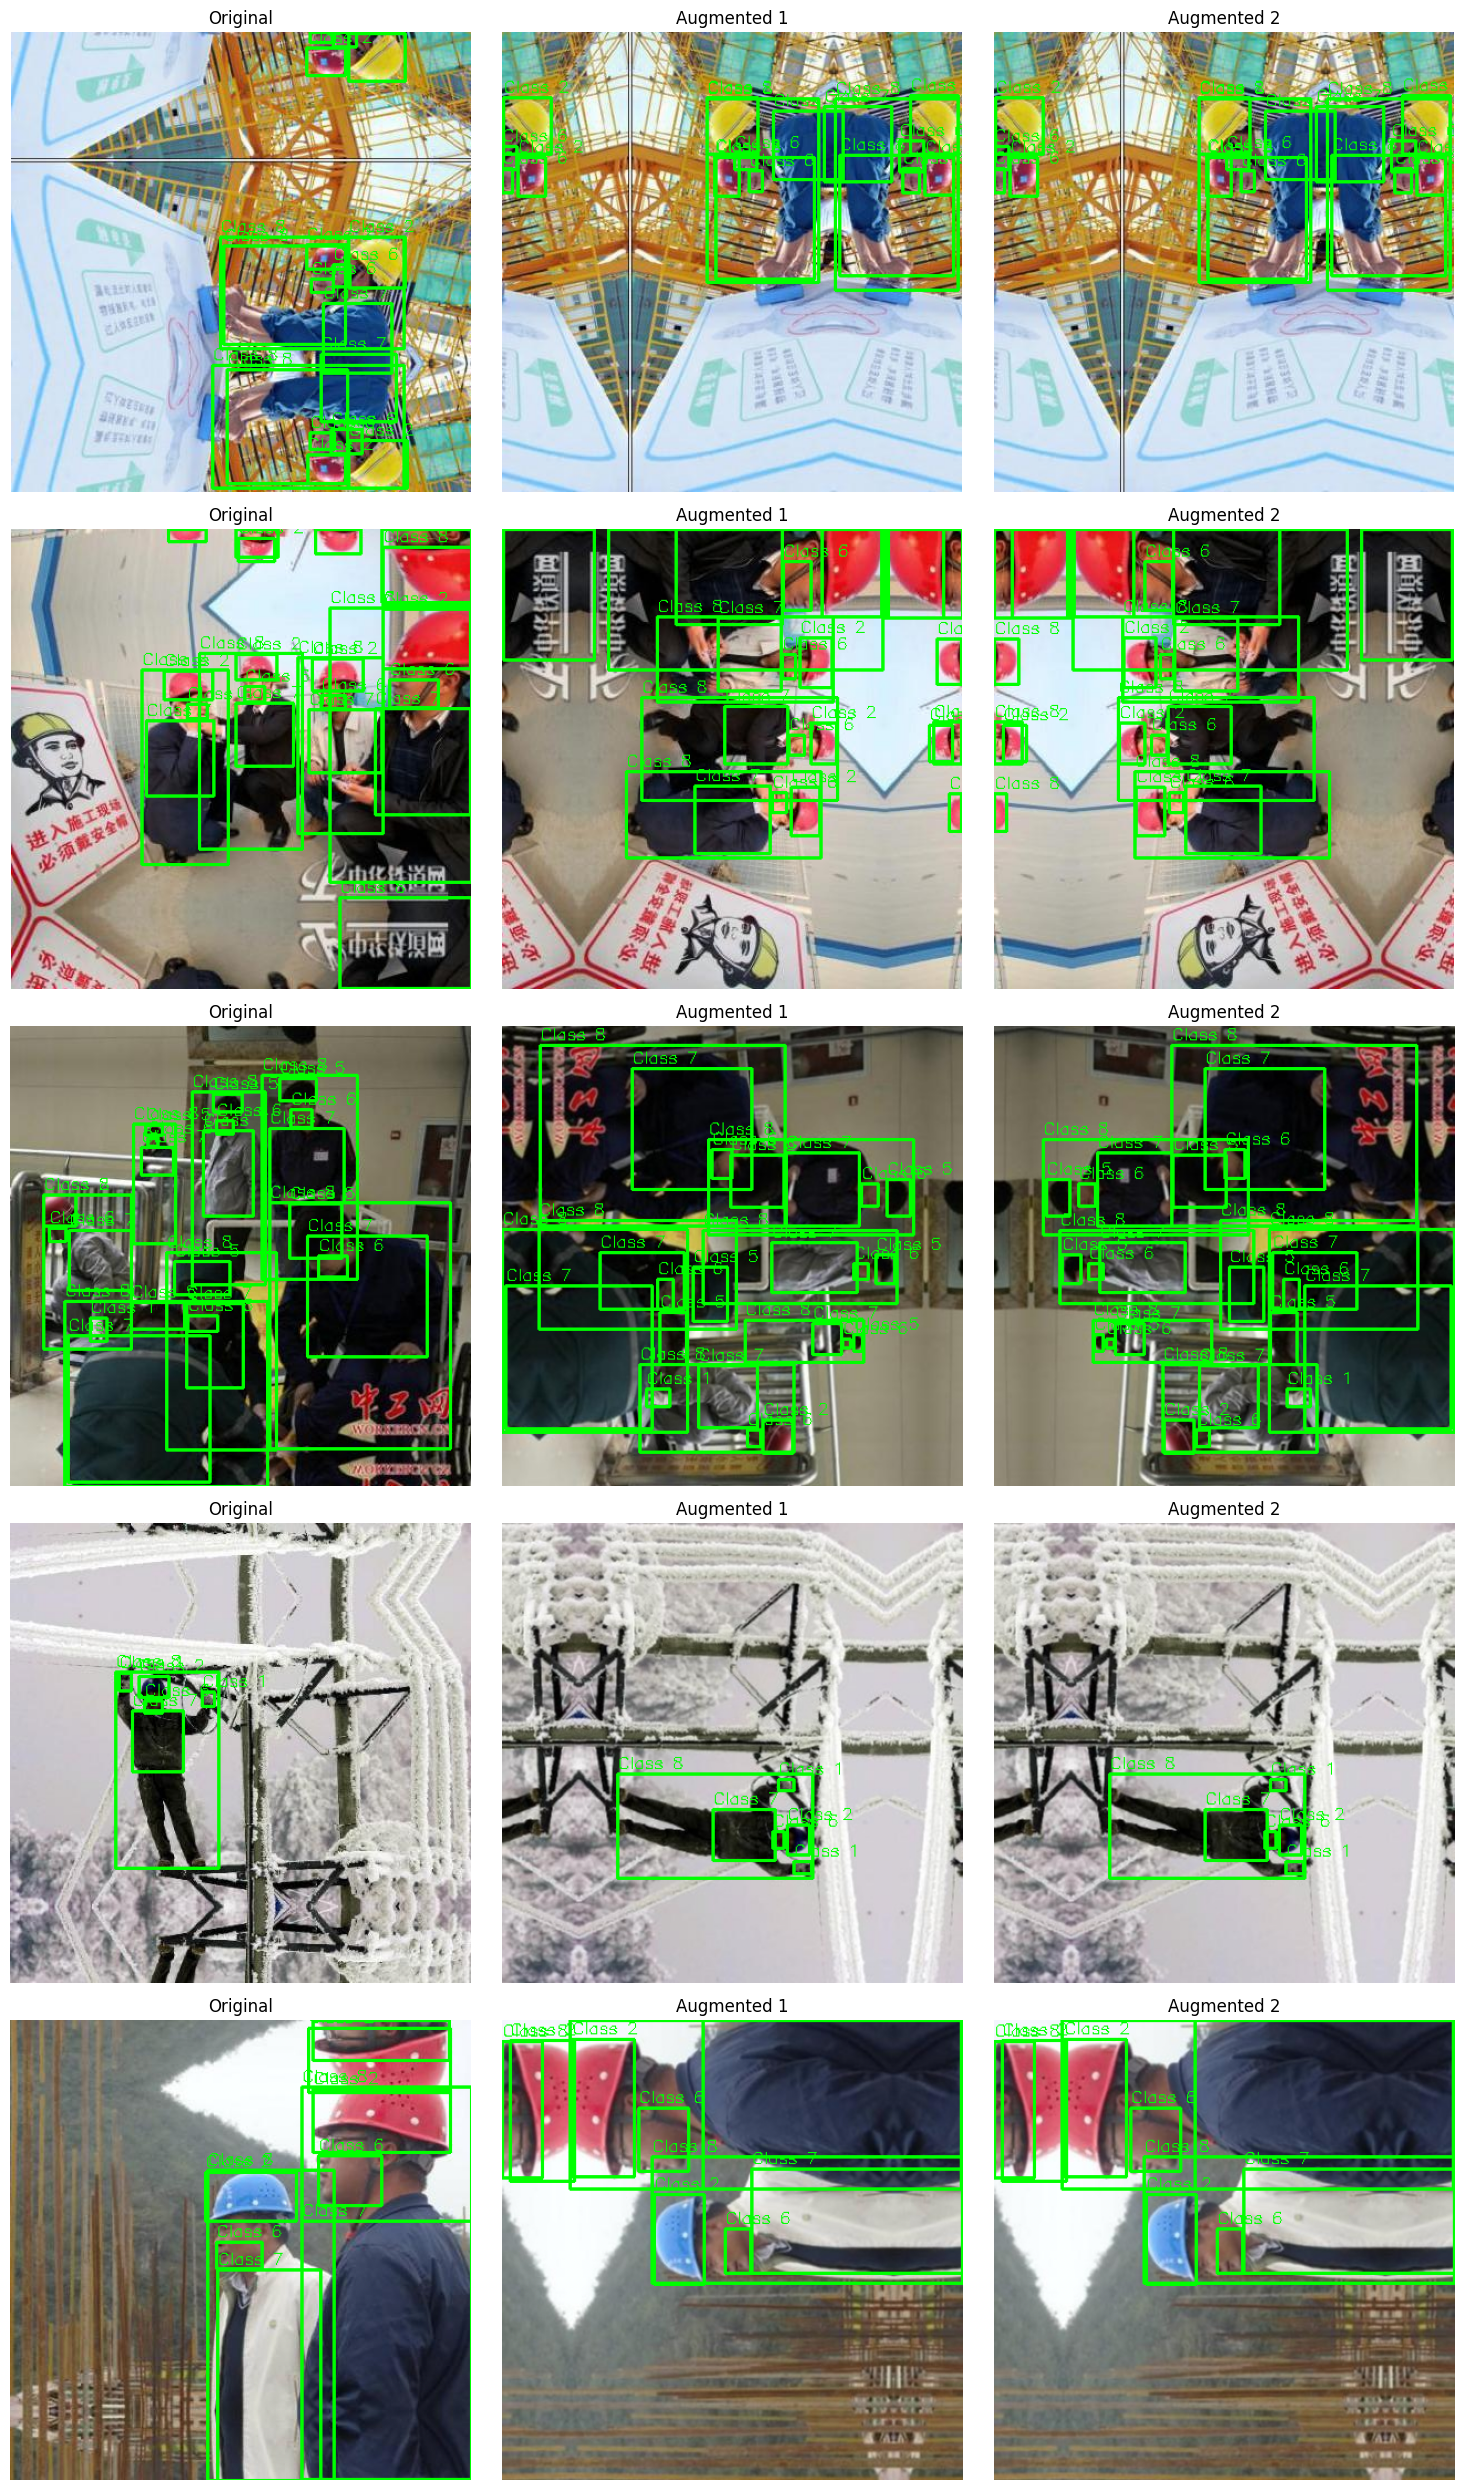

In [14]:
display_original_with_augmented_pairs(train_images_dir, train_labels_dir, aug_images_dir, aug_labels_dir, num_examples=5)

# Generate YAML configuration file

In [ ]:
import yaml
from pathlib import Path

def create_yaml_file(dataset_path, train_images, val_images, test_images=None, class_names=['dragon-fruit']):
    data = {
        'path': str(dataset_path),
        'train': str(Path(train_images).relative_to(dataset_path)),
        'val': str(Path(val_images).relative_to(dataset_path)),
    }

    if test_images:
        data['test'] = str(Path(test_images).relative_to(dataset_path))

    data['nc'] = len(class_names)
    data['names'] = class_names

    yaml_path = Path(dataset_path) / 'dataset.yaml'
    with open(yaml_path, 'w') as file:
        yaml.dump(data, file, default_flow_style=False)

    print(f"YAML file created at {yaml_path}")

In [ ]:
dataset_root = Path("./dataset")
train_images_dir = dataset_root / "train/images"
val_images_dir = dataset_root / "valid/images"
test_images_dir = dataset_root / "test/images"

In [ ]:
create_yaml_file(dataset_root, train_images_dir, val_images_dir, test_images_dir, class_names=['dragon-fruit'])

# Train YOLOv9 model

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
model = YOLO("yolov9n.pt")

results = model.train(
    data="./dataset/dataset.yaml",
    epochs=50,
    batch=16,
    lr0=1e-4,
    imgsz=640,
)

metrics = model.val()

print(metrics)

In [ ]:
mAP50 = metrics.results_dict.get('metrics/mAP50(B)', 0)
precision = metrics.results_dict.get('metrics/precision(B)', 0)
recall = metrics.results_dict.get('metrics/recall(B)', 0)

metrics_df = pd.DataFrame({
    "Metric": ["Mean Average Precision (mAP@0.5)",
               "Precision", "Recall"],
    "Value": [mAP50, precision, recall]
})

print(metrics_df)

plt.figure(figsize=(10, 6))
plt.bar(metrics_df["Metric"], metrics_df["Value"], color=['blue', 'green', 'red'])
plt.title("Model Metrics")
plt.ylabel("Value")
plt.ylim(0, 1)
plt.show()

# Exporting model to Huging Face

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")

model.export(format="onnx")

# Deploy model on Huggingface

In [ ]:
from huggingface_hub import HfApi, HfFolder, Repository

!huggingface-cli login

from huggingface_hub import create_repo, upload_file

repo_id = "felixtran/dragon-fruit-yolov8"

upload_file(
    path_or_fileobj="runs/detect/train/weights/best.pt",
    path_in_repo="model.pt",
    repo_id=repo_id,
    repo_type="model"
)

print(f"Model uploaded!")

In [ ]:
trained_model = YOLO('./runs/detect/train/weights/best.pt')

test_image_path = './pic3.png'

results = trained_model.predict(test_image_path, save=True, save_txt=True)

for result in results:
    img = result.plot()
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()